<a href="https://colab.research.google.com/github/kaidalisohaib/AICohortW24/blob/Sohaib/notebooks/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.10.1


## Step 1: Import necessary libraries

In [1]:
import os
import time
import logging
import shutil
from math import ceil
from datetime import datetime
from importlib import reload  # Not needed in Python 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, make_scorer, precision_score, balanced_accuracy_score, precision_recall_curve
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from joblib import Memory
from sklearn.pipeline import Pipeline
import onnx
from onnx import shape_inference
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from onnxruntime import InferenceSession

reload(logging)
%matplotlib inline

sns.set_context("notebook")
sns.set_theme(style="ticks")
sns.color_palette("rocket", as_cmap=True)


# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S', 
                    handlers=[
        logging.StreamHandler()
    ],)
logger = logging.getLogger(__name__)

# Create a memory object to cache the results
memory = Memory(location='cache', verbose=0)


## Step 2: Load the dataset

In [3]:
input_file_path = "https://raw.githubusercontent.com/kaidalisohaib/AICohortW24/main/data/heart_disease_health_indicators_BRFSS2015.csv"

df = pd.read_csv(input_file_path, header = 0)

df.head()

all_columns = df.columns.tolist()

# Define target column
target_column = "HeartDiseaseorAttack"

# Get all feature columns except one
all_features = all_columns
all_features.remove(target_column)

# Get numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Get non-numerical (categorical) columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("All the columns:\n", all_columns)
print("Target column:\n", target_column)
print("Features columns:\n", all_features)
print("Numerical Columns:\n",numerical_cols)
print("Categorical Columns:\n",categorical_cols)


All the columns:
 ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
Target column:
 HeartDiseaseorAttack
Features columns:
 ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
Numerical Columns:
 ['HeartDiseaseorAttack', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
Categorical Columns:
 []


## Step 3: Data exploration

### 3.1 Descriptive Statistics

In [4]:
# Print the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

# Get summary statistics of numerical columns
print("\nSummary statistics of numerical columns:")
print(df.describe())

# Get the count of unique values in each column
print("\nCount of unique values in each column:")
print(df.nunique())

print("\nCount of missing values:")
print(df.isnull().sum())

# Get the count of duplicate rows
print("\nCount of duplicated rows:")
print(df.duplicated(keep=False).sum())

# Value counts of a numerical variable
print("\nValue counts of a numerical variable:")
print(len(numerical_cols))

# Value counts of a categorical variable
print("\nValue counts of a categorical variable:")
print(len(categorical_cols))

First few rows of the dataset:
   HeartDiseaseorAttack  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0                   0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1                   0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2                   0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3                   0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4                   0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   Diabetes  PhysActivity  Fruits  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0       0.0           0.0     0.0  ...            1.0          0.0      5.0   
1       0.0           1.0     0.0  ...            0.0          1.0      3.0   
2       0.0           0.0     1.0  ...            1.0          1.0      5.0   
3       0.0           1.0     1.0  ...            1.0          0.0      2.0   
4       0.0           1.0     1.0  ...            1.0          0.0      2.0   

   MentHlth  PhysHlth  Di

### 3.2 Data Visualization

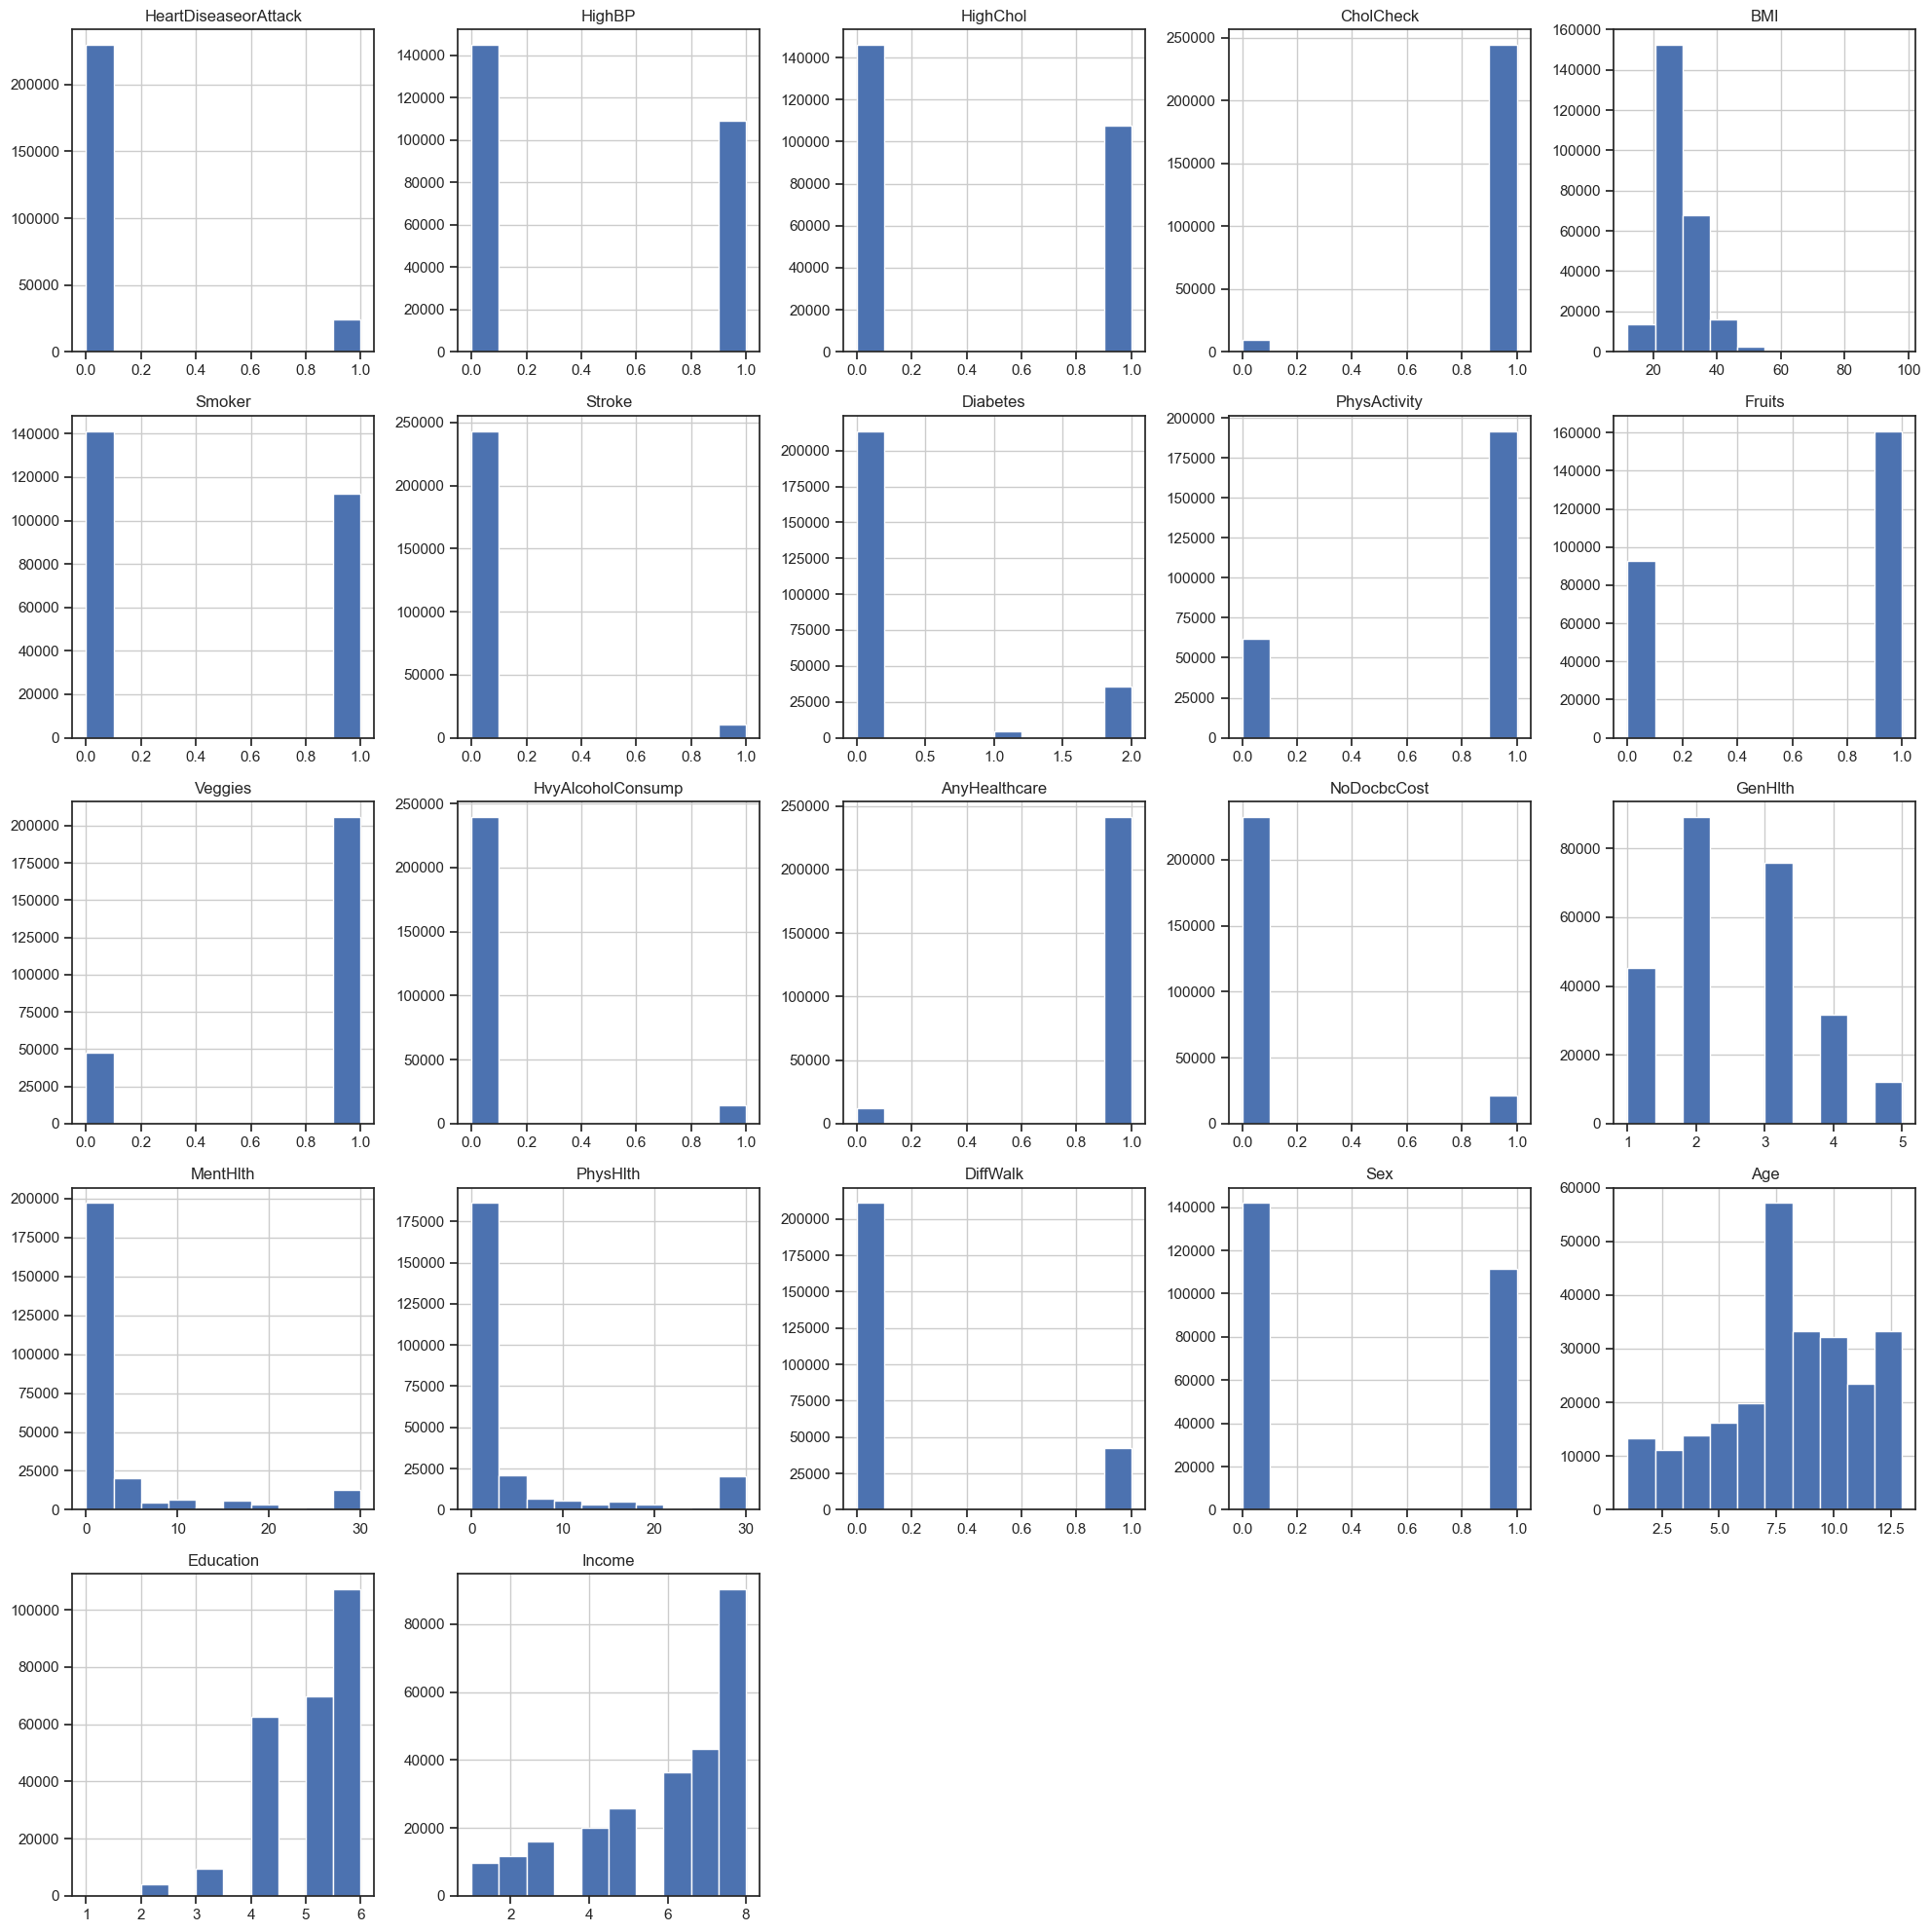

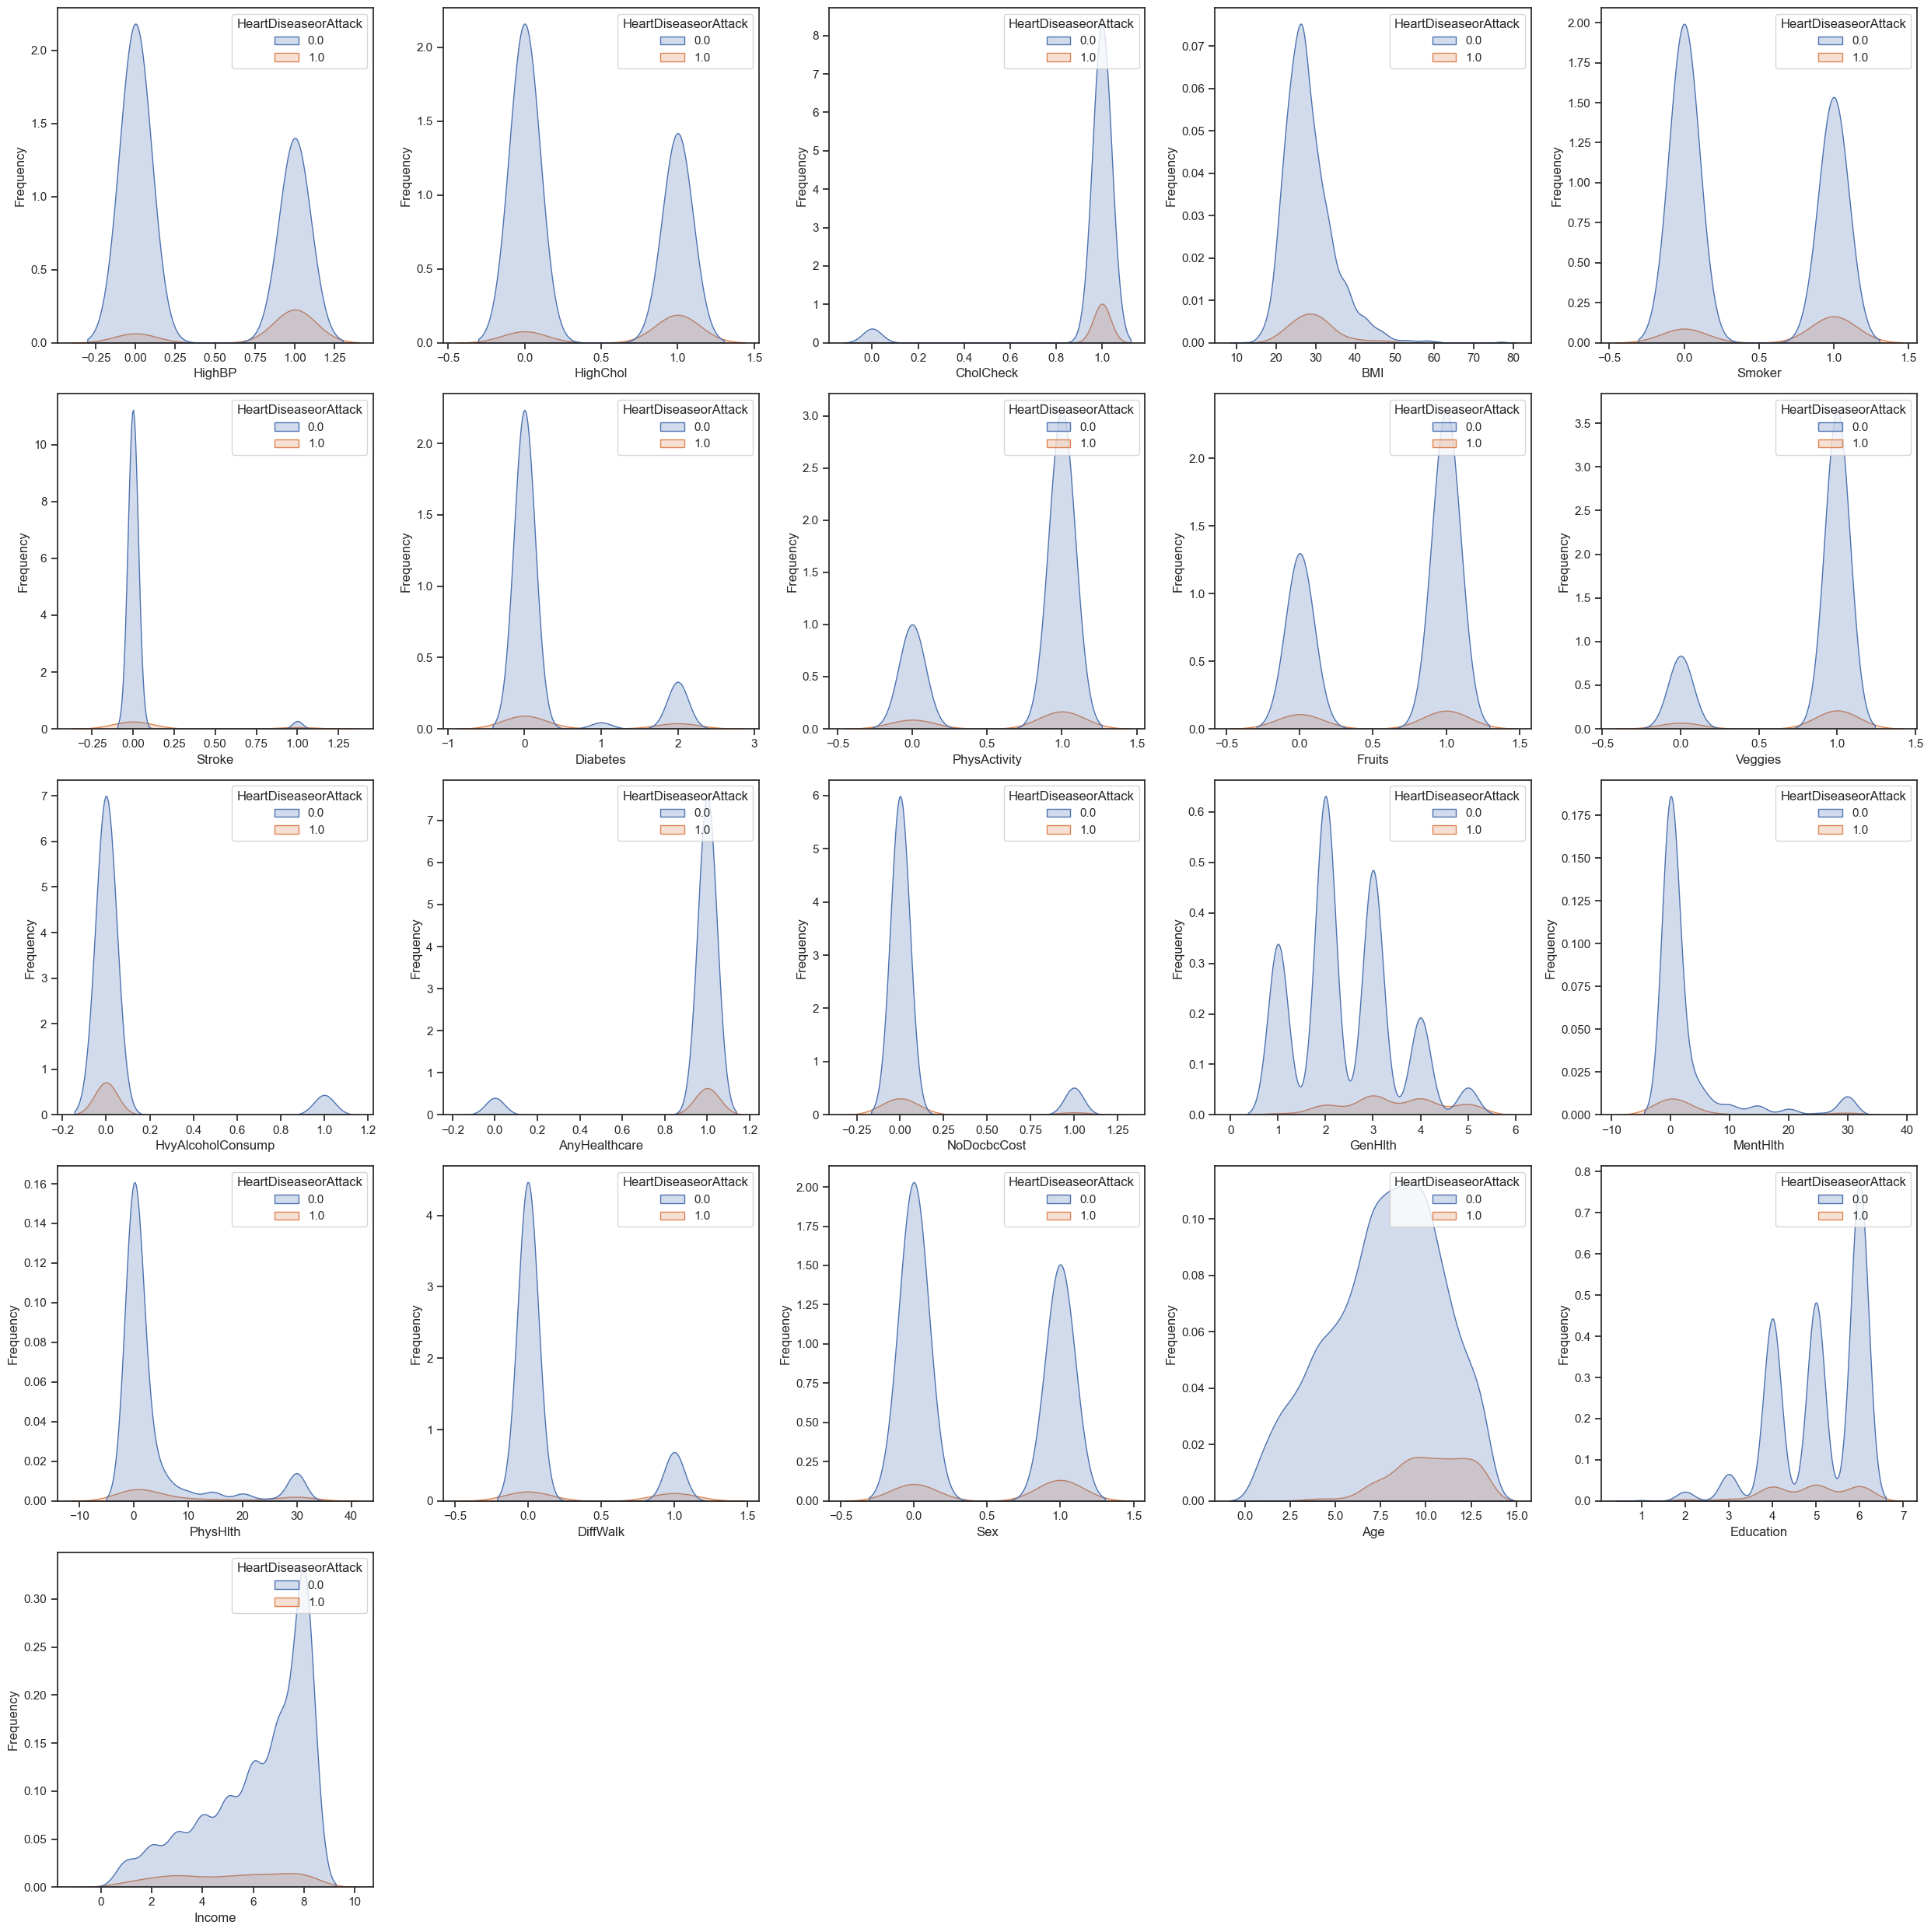

In [5]:
sample_df = df.sample(3_000, random_state=42)

df.hist(figsize=(20,20))
plt.tight_layout()
plt.show()

###########

# Define a function to create the pairplot
def create_pairplot(df, all_features, target_column):
    # Determine the number of columns in the pairplot grid
    num_cols = 5  # Adjust the number of columns as needed

    # Calculate the number of rows needed for the pairplot grid
    num_rows = (len(all_features) + num_cols - 1) // num_cols

    # Create a single figure and axes for the pairplot grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

    # Plot each feature against the target variable
    for i, feature in enumerate(all_features):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        sns.kdeplot(data=df, x=feature, hue=target_column, fill=True, ax=ax, warn_singular=False)
        ax.set_ylabel("Frequency")

    # Hide empty subplots
    for i in range(len(all_features), num_rows*num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col])

    # Show the combined pairplot image
    plt.tight_layout()
    return fig

# Call the function to create the pairplot
pairplot_fig = create_pairplot(sample_df, all_features, target_column)
plt.show()

### 3.3 Pattern identification

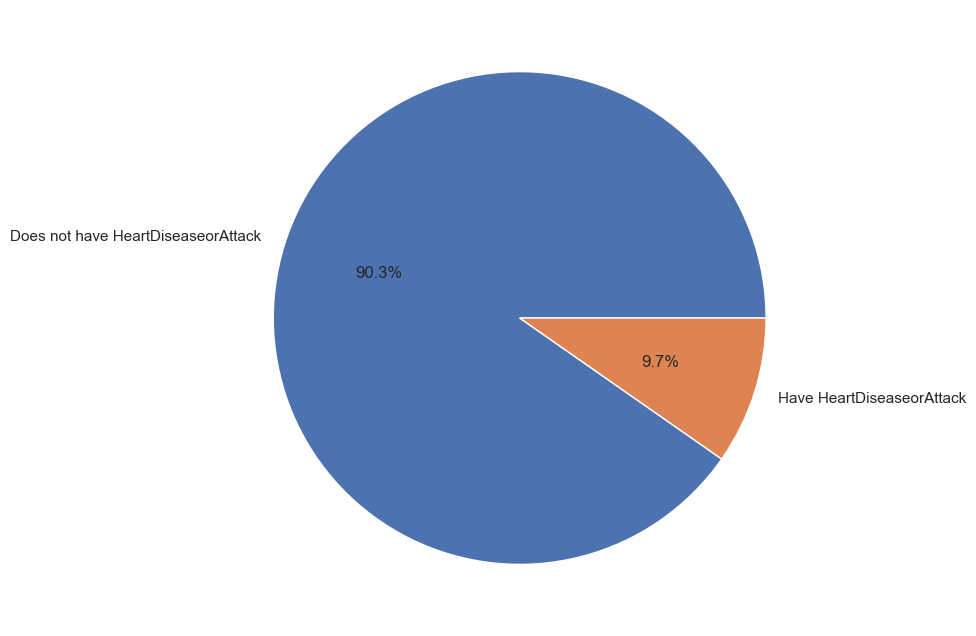

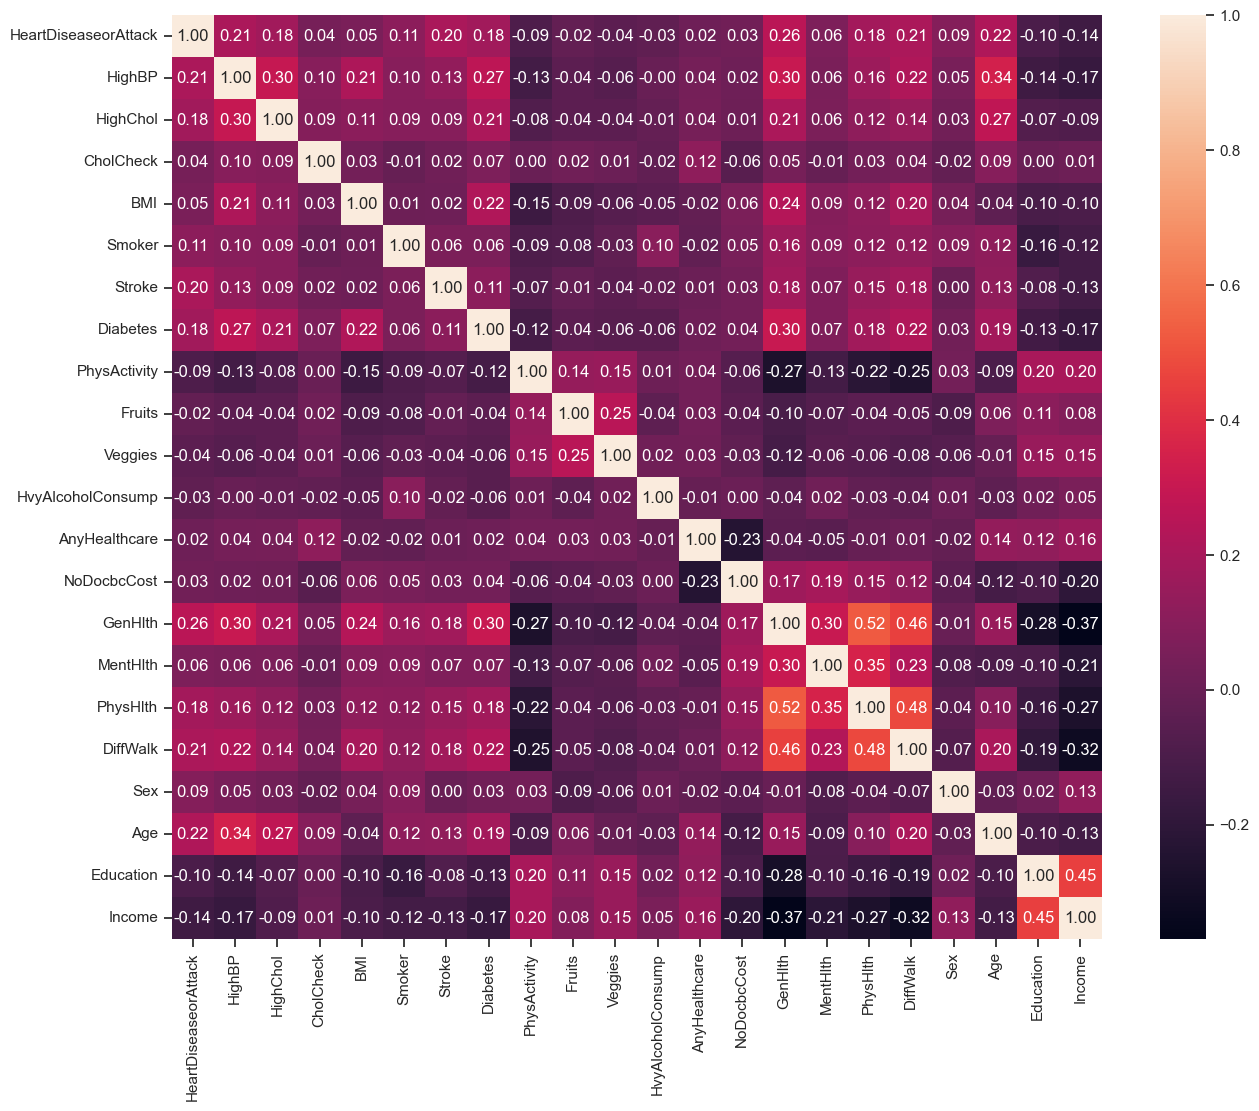

In [6]:
# plotting data on chart
# plt.pie(sample_df[target_column].value_counts(), )

fig, ax = plt.subplots(figsize=(8, 8))

_ = sample_df[target_column].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax, labels=["Does not have HeartDiseaseorAttack", "Have HeartDiseaseorAttack"])
_ = ax.yaxis.set_visible(False)
# displaying chart
plt.show()

# Correlation matrix
plt.figure(figsize=(15,12))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

## Step 4: Data preprocessing
TODO: Handle missing values, encode categorical variables, perform feature scaling, etc.

In [7]:
df.drop_duplicates(keep='first', inplace=True)
# No missing value so we're good

## Step 6: Split the dataset into train and test sets

In [8]:
# Sample the dataset
def sample_dataset(df, frac=0.1, random_state=42):
    logger.info("Sampling the dataset...")
    return df.sample(frac=frac, random_state=random_state)

# Split data into train and test sets
def split_train_test(sample_df, all_features, target_column, test_size=0.2, random_state=42):
    logger.info("Splitting data into train and test sets...")
    X_train, X_test, y_train, y_test = train_test_split(sample_df[all_features], sample_df[target_column], test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

# Call the functions to sample the dataset and split train-test sets
sample_df = sample_dataset(df, 1.0)
X_train, X_test, y_train, y_test = split_train_test(sample_df, all_features, target_column)

INFO:__main__:Sampling the dataset...
INFO:__main__:Splitting data into train and test sets...


## Step 7: Feature scaling

Feature scaling is included in the Pipeline

## Step 8: Model training

In [9]:
# Define a function to create a scorer for PR AUC
def pr_auc_scorer(y_true, y_pred):
    return average_precision_score(y_true, y_pred)

# Wrap the grid search function with the memory object
@memory.cache
def grid_search_fit(pipeline, param_grid, X_train, y_train):
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=make_scorer(pr_auc_scorer, response_method="predict"), verbose=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search

# Define resampling techniques
logger.info("Defining resampling techniques...")
resampling_techniques = {
    'smote': SMOTE(random_state=42),
    'adasyn': ADASYN(random_state=42),
    'borderline_smote': BorderlineSMOTE(random_state=42),
    'svm_smote': SVMSMOTE(random_state=42),
    'random_under_sampler': RandomUnderSampler(random_state=42),
    'tomek_links': TomekLinks(),
    'edited_nearest_neighbours': EditedNearestNeighbours()
}

# Define classifiers
logger.info("Defining classifiers...")
classifiers = {
    'rf': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'gb': GradientBoostingClassifier(random_state=42)
}

# Define pipelines for different strategies
logger.info("Creating pipelines...")
pipelines = {}
for resampling_name, resampling_technique in resampling_techniques.items():
    for classifier_name, classifier in classifiers.items():
        pipe_name = f"{resampling_name}_{classifier_name}"
        scaler = MinMaxScaler()
        poly_features = PolynomialFeatures(degree=2)  # Adjust degree as needed
        pipeline = Pipeline([
            ('scaler', scaler),
            ('poly_features', poly_features),  # Add PolynomialFeatures
            ('classifier', classifier)
        ], memory="cache")
        pipelines[pipe_name] = (pipeline, resampling_technique)

# Define parameter grids for grid search
logger.info("Defining parameter grids for grid search...")
param_grids = {
    'rf': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20]
    },
    'gb': {
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.01, 0.1]
    }
}

# Perform grid search and evaluate models
logger.info("Performing grid search and evaluating models...")
results = {}
pipeline_total = len(pipelines)
start = time.time()
for idx, (name, (pipeline, resampling_technique)) in enumerate(pipelines.items()):
    logger.info(f"Training {name} {100*idx/pipeline_total:.1f}%...")
    classifier_name = name.split('_')[-1]
    param_grid = param_grids[classifier_name]
    X_train_resampled, y_train_resampled = resampling_technique.fit_resample(X_train, y_train)
    # Call the grid search function, which will check the cache before running
    grid_search = grid_search_fit(pipeline, param_grid, X_train_resampled, y_train_resampled)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred)
    results[name] = {
        'best_model': best_model,
        'classification_report': report
    }

elapsed_time = time.time() - start

# Convert elapsed time to hours, minutes, and seconds
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

# Print elapsed time in a nice format
print(f"Total Training Time: {int(hours):02d} hours, {int(minutes):02d} minutes, {seconds:.2f} seconds")

# Print results
logger.info("Printing results...")
for name, result in results.items():
    print(f"\n{name.upper()} MODEL:")
    print("Best Model Parameters:", result['best_model'].get_params())
    print("Classification Report:")
    print(result['classification_report'])


INFO:__main__:Defining resampling techniques...
INFO:__main__:Defining classifiers...
INFO:__main__:Creating pipelines...
INFO:__main__:Defining parameter grids for grid search...
INFO:__main__:Performing grid search and evaluating models...
INFO:__main__:Training smote_rf 0.0%...


Fitting 3 folds for each of 4 candidates, totalling 12 fits


INFO:__main__:Training smote_gb 7.1%...


Fitting 3 folds for each of 4 candidates, totalling 12 fits


INFO:__main__:Training adasyn_rf 14.3%...


Fitting 3 folds for each of 4 candidates, totalling 12 fits


INFO:__main__:Training adasyn_gb 21.4%...


Fitting 3 folds for each of 4 candidates, totalling 12 fits


INFO:__main__:Training borderline_smote_rf 28.6%...


Fitting 3 folds for each of 4 candidates, totalling 12 fits


INFO:__main__:Training borderline_smote_gb 35.7%...


Fitting 3 folds for each of 4 candidates, totalling 12 fits


INFO:__main__:Training svm_smote_rf 42.9%...


Fitting 3 folds for each of 4 candidates, totalling 12 fits


INFO:__main__:Training svm_smote_gb 50.0%...


Fitting 3 folds for each of 4 candidates, totalling 12 fits


INFO:__main__:Training random_under_sampler_rf 57.1%...


Fitting 3 folds for each of 4 candidates, totalling 12 fits


INFO:__main__:Training random_under_sampler_gb 64.3%...


Fitting 3 folds for each of 4 candidates, totalling 12 fits


INFO:__main__:Training tomek_links_rf 71.4%...


Fitting 3 folds for each of 4 candidates, totalling 12 fits


INFO:__main__:Training tomek_links_gb 78.6%...


Fitting 3 folds for each of 4 candidates, totalling 12 fits


INFO:__main__:Training edited_nearest_neighbours_rf 85.7%...


Fitting 3 folds for each of 4 candidates, totalling 12 fits


INFO:__main__:Training edited_nearest_neighbours_gb 92.9%...


Fitting 3 folds for each of 4 candidates, totalling 12 fits


INFO:__main__:Printing results...


Total Training Time: 08 hours, 04 minutes, 8.27 seconds

SMOTE_RF MODEL:
Best Model Parameters: {'memory': None, 'steps': [('scaler', MinMaxScaler()), ('poly_features', PolynomialFeatures()), ('classifier', RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=200,
                       random_state=42))], 'verbose': False, 'scaler': MinMaxScaler(), 'poly_features': PolynomialFeatures(), 'classifier': RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=200,
                       random_state=42), 'scaler__clip': False, 'scaler__copy': True, 'scaler__feature_range': (0, 1), 'poly_features__degree': 2, 'poly_features__include_bias': True, 'poly_features__interaction_only': False, 'poly_features__order': 'C', 'classifier__bootstrap': True, 'classifier__ccp_alpha': 0.0, 'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__max_leaf_nodes': None, 'cl

## Step 9: Model evaluation

For our binary classification challenge PR AUC Score is more important

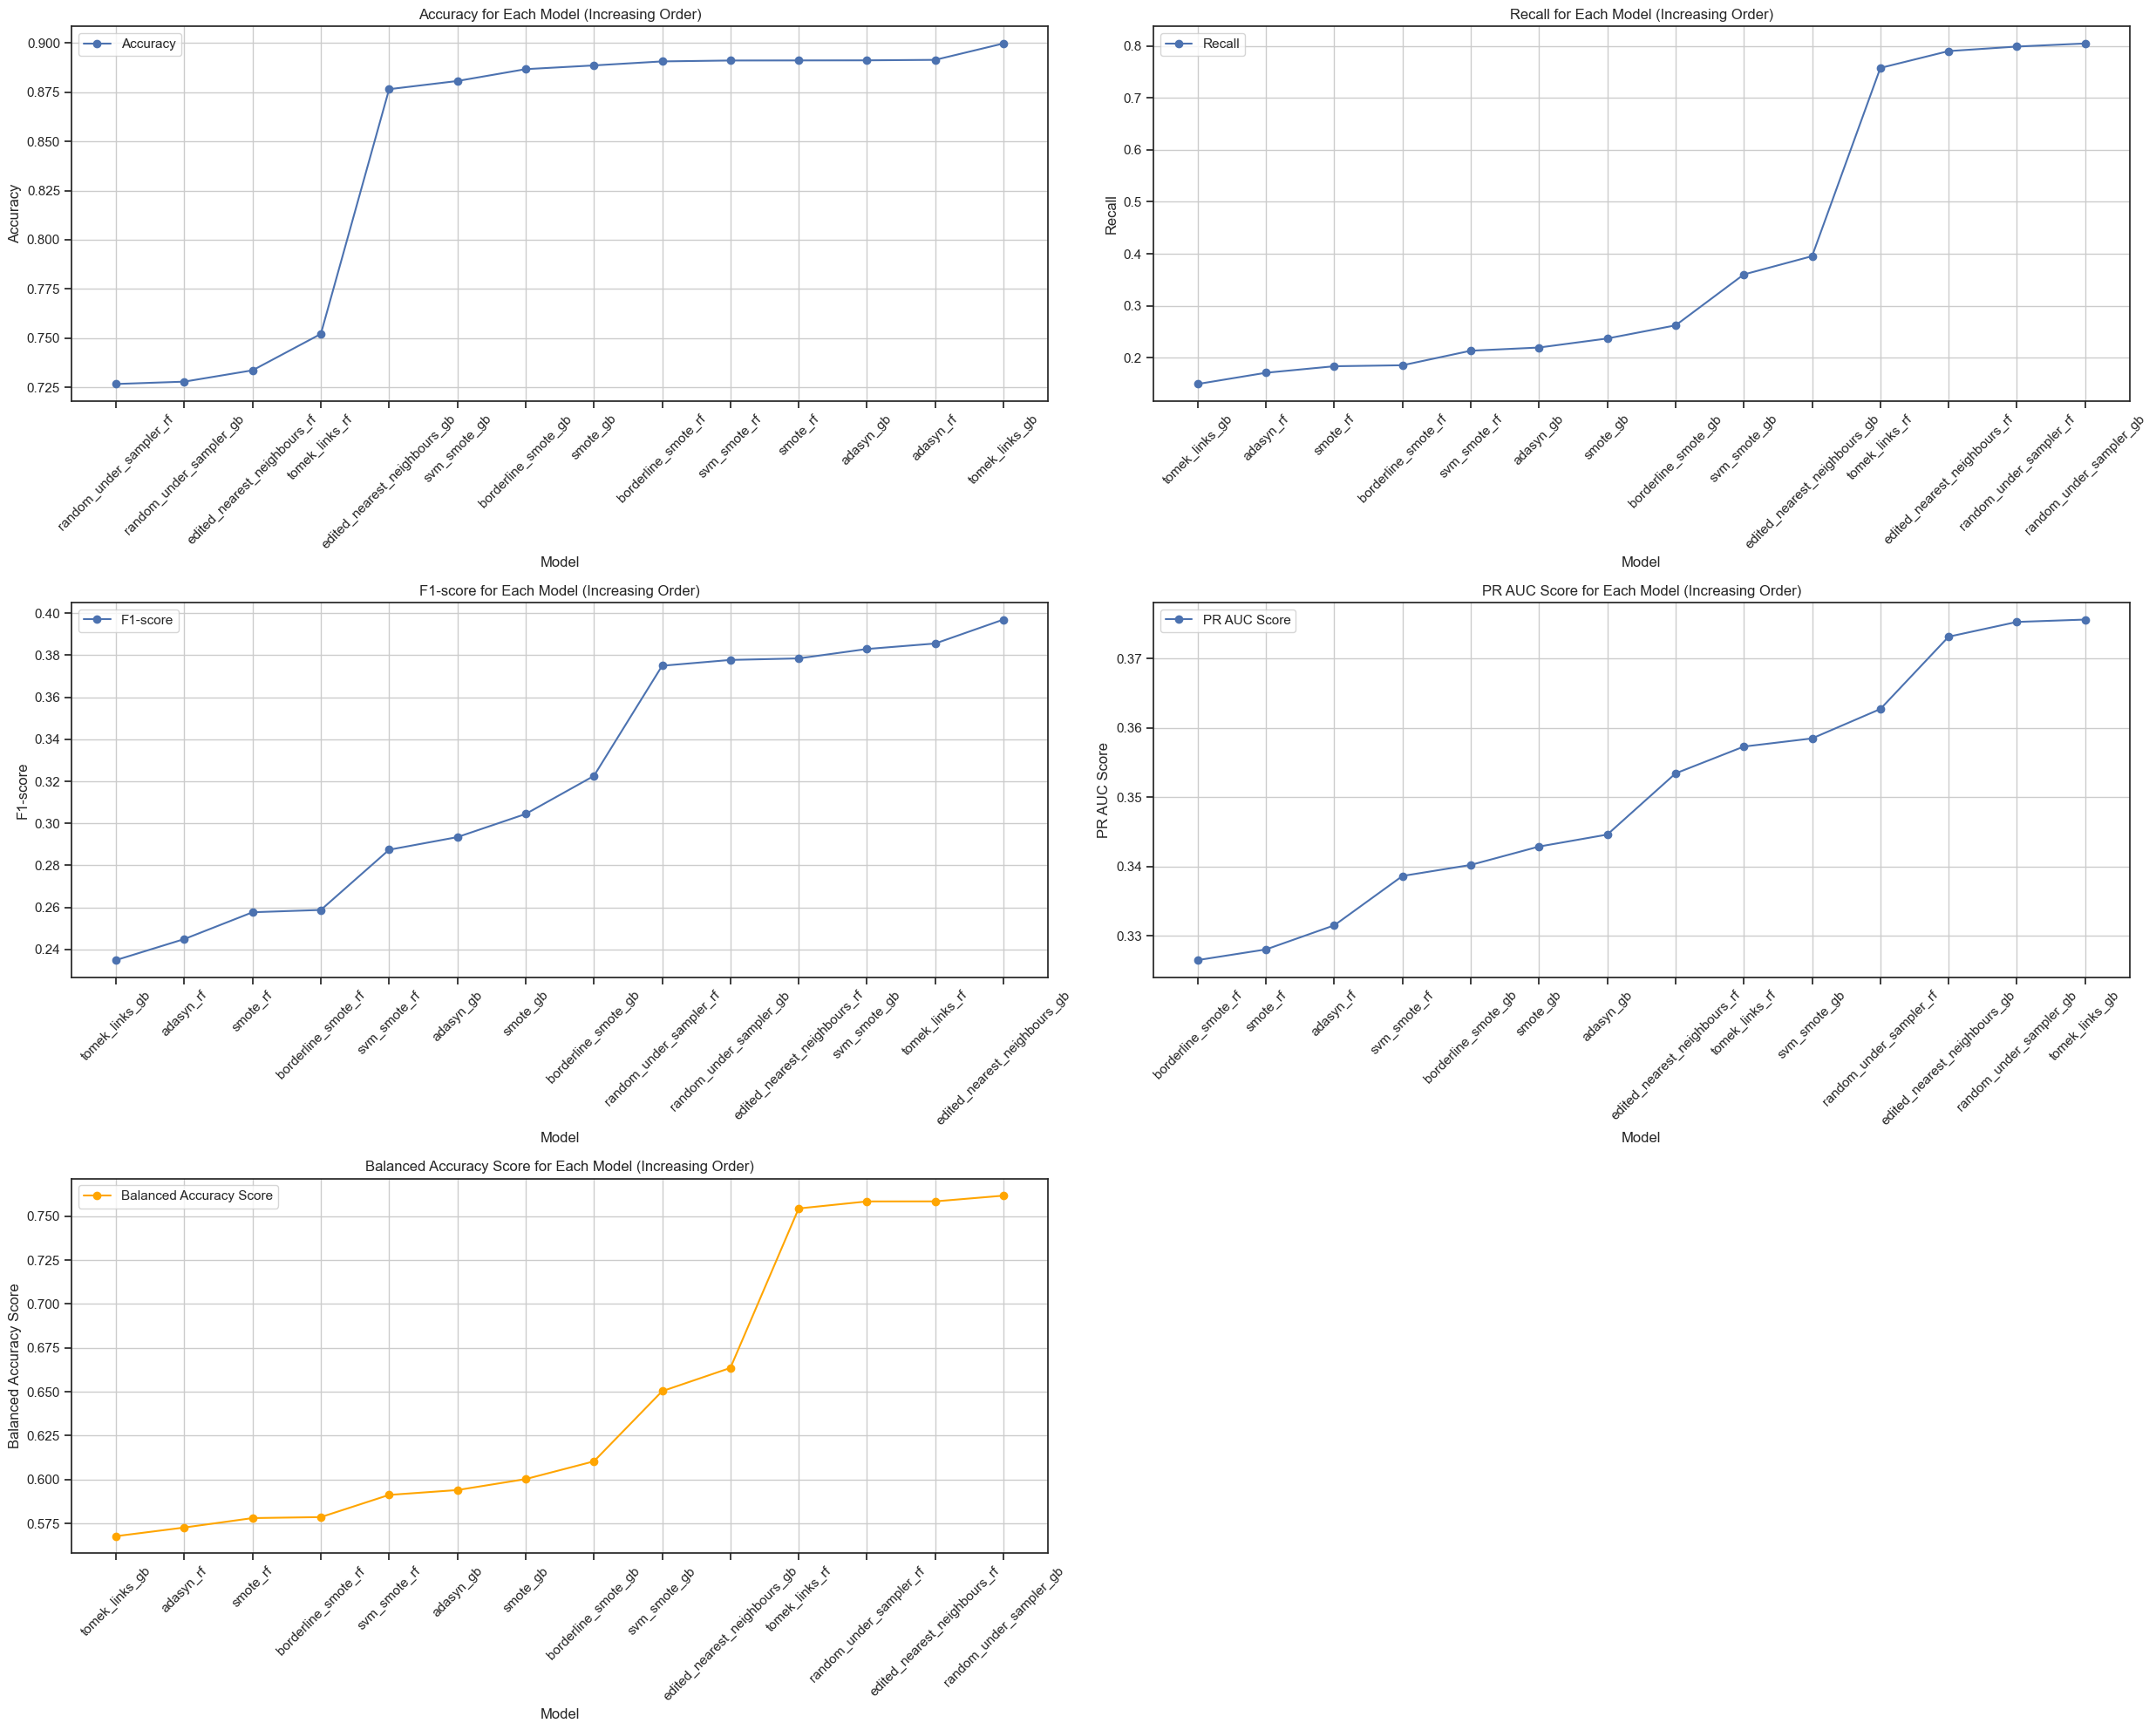

In [10]:
# Define a function to evaluate models and collect scores
def evaluate_models(results, X_test, y_test):
    model_scores = []
    for name, result in results.items():
        pr_auc = average_precision_score(y_test, result['best_model'].predict_proba(X_test)[:, 1])
        balanced_accuracy = balanced_accuracy_score(y_test, result['best_model'].predict(X_test))
        report_dict = classification_report(y_test, result['best_model'].predict(X_test), output_dict=True)
        accuracy = report_dict['accuracy']
        recall = report_dict['1.0']['recall'] if '1.0' in report_dict else 0  # Recall for positive class
        # F1-score for positive class
        f1_score = report_dict['1.0']['f1-score'] if '1.0' in report_dict else 0
        # Calculate precision for positive class
        positive_precision = precision_score(y_test, result['best_model'].predict(X_test), pos_label=1)
        # Append the scores to the list
        model_scores.append((name, accuracy, recall, f1_score, pr_auc, balanced_accuracy, positive_precision))

    # Sort the models based on each metric score in increasing order
    model_scores_accuracy = sorted(model_scores, key=lambda x: x[1])
    model_scores_recall = sorted(model_scores, key=lambda x: x[2])
    model_scores_f1_score = sorted(model_scores, key=lambda x: x[3])
    model_scores_pr_auc = sorted(model_scores, key=lambda x: x[4])
    model_scores_balanced_accuracy = sorted(model_scores, key=lambda x: x[5])

    # Extract model names and corresponding scores for plotting
    model_names_accuracy = [name for name, _, _, _, _, _, _ in model_scores_accuracy]
    model_names_recall = [name for name, _, _, _, _, _, _ in model_scores_recall]
    model_names_f1_score = [name for name, _, _, _, _, _, _ in model_scores_f1_score]
    model_names_pr_auc = [name for name, _, _, _, _, _, _ in model_scores_pr_auc]
    model_names_balanced_accuracy = [name for name, _, _, _, _, _, _ in model_scores_balanced_accuracy]

    accuracy_scores = [accuracy for _, accuracy, _, _, _, _, _ in model_scores_accuracy]
    recall_scores = [recall for _, _, recall, _, _, _, _ in model_scores_recall]
    f1_scores = [f1_score for _, _, _, f1_score, _, _, _ in model_scores_f1_score]
    pr_auc_scores = [pr_auc for _, _, _, _, pr_auc, _, _ in model_scores_pr_auc]
    balanced_accuracy_scores = [balanced_precision for _, _, _, _, _, balanced_precision, _ in model_scores_balanced_accuracy]
    return (model_scores, model_names_accuracy, model_names_recall, model_names_f1_score, model_names_pr_auc, model_names_balanced_accuracy,
            accuracy_scores, recall_scores, f1_scores, pr_auc_scores, balanced_accuracy_scores)

# Call the function to evaluate models and collect scores
(model_scores, model_names_accuracy, model_names_recall, model_names_f1_score, model_names_pr_auc, model_names_balanced_accuracy,
 accuracy_scores, recall_scores, f1_scores, pr_auc_scores, balanced_accuracy_scores) = evaluate_models(results, X_test, y_test)
    
# Plot scores
plt.figure(figsize=(25, 20))

# Accuracy
plt.subplot(3, 2, 1)
plt.plot(model_names_accuracy, accuracy_scores, label='Accuracy', marker='o')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Model (Increasing Order)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Recall
plt.subplot(3, 2, 2)
plt.plot(model_names_recall, recall_scores, label='Recall', marker='o')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Recall for Each Model (Increasing Order)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# F1-score
plt.subplot(3, 2, 3)
plt.plot(model_names_f1_score, f1_scores, label='F1-score', marker='o')
plt.xlabel('Model')
plt.ylabel('F1-score')
plt.title('F1-score for Each Model (Increasing Order)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# PR AUC Score
plt.subplot(3, 2, 4)
plt.plot(model_names_pr_auc, pr_auc_scores, label='PR AUC Score', marker='o')
plt.xlabel('Model')
plt.ylabel('PR AUC Score')
plt.title('PR AUC Score for Each Model (Increasing Order)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Balanced Precision Score
plt.subplot(3, 2, 5)
plt.plot(model_names_balanced_accuracy, balanced_accuracy_scores, label='Balanced Accuracy Score', marker='o', color='orange')
plt.xlabel('Model')
plt.ylabel('Balanced Accuracy Score')
plt.title('Balanced Accuracy Score for Each Model (Increasing Order)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


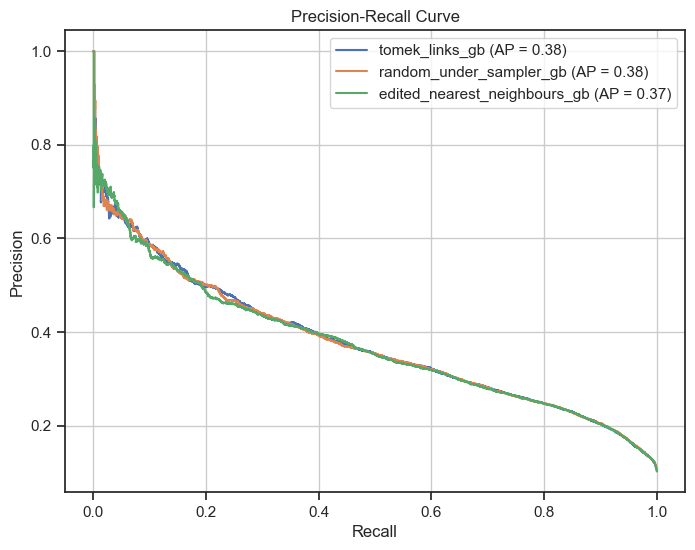

In [11]:
# Assuming model_scores is a list of (model_name, accuracy, recall, f1_score, pr_auc, balanced_accuracy, positive_precision) tuples
top_models = sorted(model_scores, key=lambda x: x[4], reverse=True)[:3]

plt.figure(figsize=(8, 6))
for model_name, _, _, _, _, _, _ in top_models:
    # Assuming model_dict contains the trained model objects
    model =  results[model_name]["best_model"]
    
    # Predict probabilities on the test set
    y_scores = model.predict_proba(X_test)[:, 1]
    
    # Compute precision and recall
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    
    # Calculate average precision
    avg_precision = average_precision_score(y_test, y_scores)
    
    # Plot PR curve
    plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

## Step 10: Confusion matrix

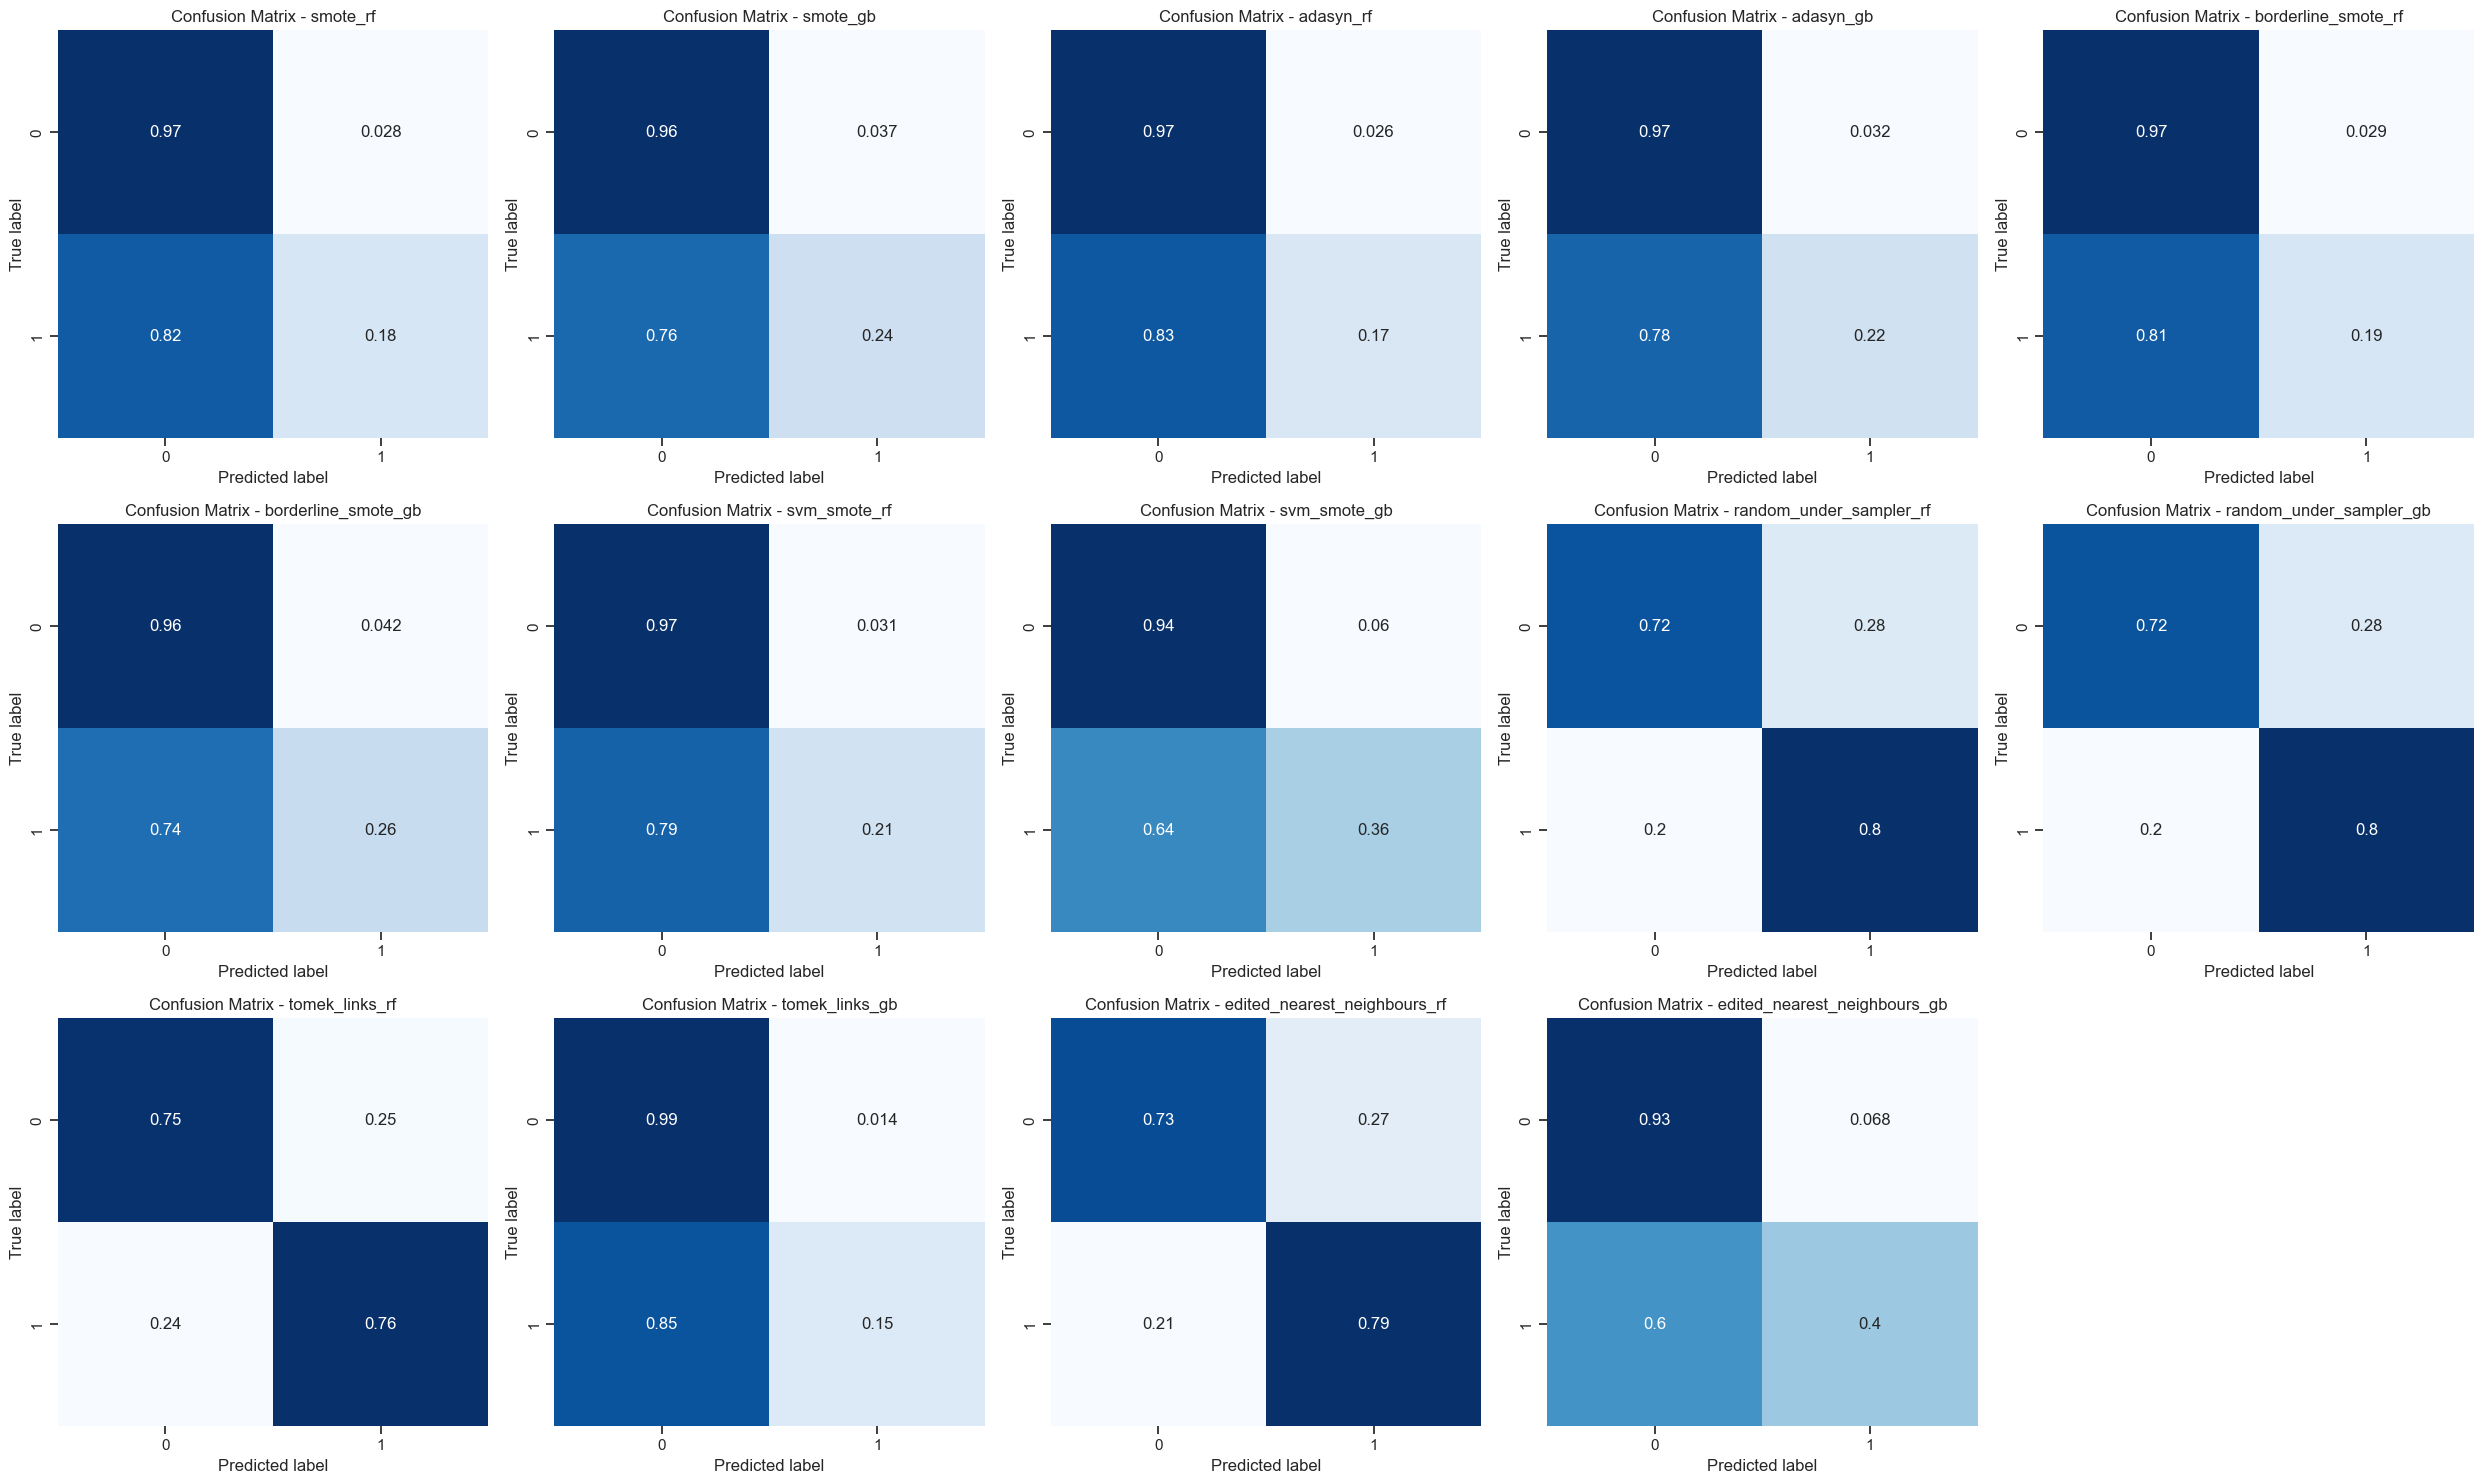

In [12]:
# Define the number of rows and columns for the subplots grid
num_rows = 3
num_cols = ceil(len(results)/num_rows)

# Create a new figure with a specified size
plt.figure(figsize=(25, 15))

# Loop through each model and plot its confusion matrix
for i, (name, result) in enumerate(results.items(), 1):
    # Get the predicted labels from the model
    y_pred = result['best_model'].predict(X_test)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize="true")
    
    # Create a new subplot for the current model
    plt.subplot(num_rows, num_cols, i)
    
    # Plot the confusion matrix
    sns.heatmap(cm, annot=True, cmap="Blues", cbar=False)
    
    # Set the title and labels for the subplot
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

# Adjust the layout of subplots to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

## Step 11: Choose the best model

Since PR AUC values are similar across models, balanced accuracy serves as a reliable alternative metric for evaluating and selecting the best-performing model, especially in scenarios with imbalanced datasets.

**Keeping only the gb models because the rf models take way too much space (>100MB) compared to gb (<200KB)**

In [38]:
# Assuming model_scores is a list of (model_name, accuracy, recall, f1_score, pr_auc, balanced_accuracy, positive_precision) tuples
gb_model_scores = [(name, acc, recall, f1, pr_auc, bal_acc, prec) for name, acc, recall, f1, pr_auc, bal_acc, prec in model_scores if 'gb' in name.lower()]
print(gb_model_scores)

best_model_name = sorted(gb_model_scores, key=lambda x: x[5], reverse=True)[0][0]
best_model = results[best_model_name]["best_model"]
print(best_model_name)

print("Best Model based on Recall Score:")
print(f"Model Name: {best_model_name}")
print("Classification report:\n", results[best_model_name]["classification_report"])
print(f"Model Parameters: {results[best_model_name]['best_model'].get_params()}")

[('smote_gb', 0.888656787866919, 0.23728813559322035, 0.3044719314938154, 0.3428830312179171, 0.6002503922140023, 0.4247250663632916), ('adasyn_gb', 0.8912461648932698, 0.21991525423728814, 0.29346904156064463, 0.34460805045668524, 0.5940010832381484, 0.4409515717926933), ('borderline_smote_gb', 0.8867637139064778, 0.2625, 0.3225722468107264, 0.3402347525587831, 0.6103585675485608, 0.41829844699527347), ('svm_smote_gb', 0.8807363404921992, 0.3603813559322034, 0.3829787234042553, 0.35846605289863076, 0.6503388458735634, 0.40859956761950517), ('random_under_sampler_gb', 0.7278325391126488, 0.8044491525423729, 0.37777335588498656, 0.3752499406081947, 0.7617560649827804, 0.24684696398387726), ('tomek_links_gb', 0.8998193963922797, 0.14978813559322035, 0.23496178132269857, 0.37559220184782216, 0.5677281730903998, 0.5446841294298922), ('edited_nearest_neighbours_gb', 0.8765802815675523, 0.39555084745762714, 0.3969806506485222, 0.373125172744015, 0.6635949547325238, 0.3984208279982928)]
rando

## Step 12: Save the model

**gitignore is only keeping gb models because rf models are too big**

In [44]:
# Define initial types based on your input data
initial_types = [('input', FloatTensorType([None, X_train.shape[1]]))]

# Save all gb models because it takes a lot of time to train them
for model_name, model_data in results.items():
    logging.info(f"Saving Model '{model_name}' ...")
    
    model = model_data["best_model"]
    # Convert the model to ONNX format with initial types
    onnx_model = convert_sklearn(model, model_name, initial_types=initial_types)

    # Infer shapes (optional but recommended)
    onnx_model = shape_inference.infer_shapes(onnx_model)

    # Get the current date and time
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    # Define the path to save the ONNX model with timestamp
    onnx_file_path = f'../models/all_models/{model_name.replace(" ", "_").lower()}_{current_time}.onnx'

    # Save the ONNX model to a file
    onnx.save_model(onnx_model, onnx_file_path)
    
    # Log the saved model
    logger.info(f"Model '{model_name}' saved successfully at '{onnx_file_path}'.")



2024-03-02 11:33:03 - INFO - Best model 'random_under_sampler_gb' saved successfully at '../models/best_random_under_sampler_gb_2024-03-02_11-33-03.onnx'.


### Simply testing the model from the onnx file.